In [ ]:
#| default_exp deepfluoro

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from pathlib import Path

import h5py
import numpy as np
import torch
from torchio import LabelMap, ScalarImage, Subject
from torchio.transforms.preprocessing import ToCanonical
from torchvision.transforms.functional import center_crop, gaussian_blur

from diffdrr.data import read
from diffdrr.pose import RigidTransform
from diffdrr.utils import parse_intrinsic_matrix

from diffdrrdata.utils import load_file

## Dataset

The [`DeepFluoro`](https://github.com/rg2/DeepFluoroLabeling-IPCAI2020) dataset is a collection of pelvic CT and X-ray images from 6 cadaveric subjects from Johns Hopkins University. For each subject, there is

- One 3D CT volume
- One 3D labelmap for the CT
- Between 24-111 2D X-ray fluoroscopy images, depending on the subject

In total, the dataset comprises six CT volumes and 366 X-ray images (with ground truth camera poses).

In [ ]:
#| export
class DeepFluoroDataset(torch.utils.data.Dataset):
    """
    A `torch.utils.data.Dataset` that stores the imaging data for subjects
    in the `DeepFluoro` dataset and provides an iterator over the X-ray
    fluoroscopy images and associated poses for each subject. Imaging data
    can be passed to a `diffdrr.drr.DRR` to renderer DRRs from ground truth
    camera poses.
    """

    def __init__(
        self,
        id_number: int,  # Subject ID in {1, ..., 6}
        preprocess: bool = True,  # Convert X-rays from exponentiated to linear form
        bone_attenuation_multiplier: float = 1.0,  # Scalar multiplier on density of high attenuation voxels (from `DiffDRR`, see [here](https://vivekg.dev/DiffDRR/tutorials/introduction.html#changing-the-appearance-of-the-rendered-drrs))
        labels: int | list = None,  # Labels from the mask of structures to render
        batchless: bool = False,  # Return unbatched images and poses (e.g., to interface with a `torch.utils.data.DataLoader`)
    ):
        super().__init__()

        # Load the subject
        (
            self.subject,
            self.projections,
            self.anatomical2world,
            self.world2camera,
            self.focal_len,
            self.height,
            self.width,
            self.delx,
            self.dely,
            self.x0,
            self.y0,
        ) = load(id_number, bone_attenuation_multiplier, labels)

        self.preprocess = preprocess
        if self.preprocess:
            self.height -= 100
            self.width -= 100
        self.batchless = batchless

        # Miscellaneous transformation matrices for wrangling SE(3) poses
        self.flip_z = RigidTransform(
            torch.tensor(
                [
                    [0, 1, 0, 0],
                    [-1, 0, 0, 0],
                    [0, 0, -1, 0],
                    [0, 0, 0, 1],
                ]
            ).to(torch.float32)
        )
        self.rot_180 = RigidTransform(
            torch.tensor(
                [
                    [-1, 0, 0, 0],
                    [0, -1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1],
                ]
            ).to(torch.float32)
        )
        self.reorient = RigidTransform(self.subject.reorient)

    def __len__(self):
        return len(self.projections)

    def __iter__(self):
        return iter(self[idx] for idx in range(len(self)))

    def __getitem__(self, idx):
        img = torch.from_numpy(self.projections[f"{idx:03d}/image/pixels"][:])
        pose = self.projections[f"{idx:03d}/gt-poses/cam-to-pelvis-vol"][:]
        pose = RigidTransform(torch.from_numpy(pose))
        pose = (
            self.rot_180
            .compose(self.flip_z)
            .compose(self.world2camera.inverse())
            .compose(pose)
            .compose(self.anatomical2world)
            .compose(self.rot_180)
        )
        if self.rot_180_for_up(idx):
            img = torch.rot90(img, k=2)
            pose = self.rot_180.compose(pose)
        pose = self.reorient.inverse().compose(pose)
        img = img.unsqueeze(0).unsqueeze(0)
        if self.preprocess:
            img = preprocess(img)
        if self.batchless:
            return img[0], pose.matrix[0]
        else:
            return img, pose

    def rot_180_for_up(self, idx):
        return self.projections[f"{idx:03d}/rot-180-for-up"][()]

In [ ]:
#| exporti
def parse_volume(subject, bone_attenuation_multiplier, labels):
    # Get all parts of the volume
    volume = subject["vol/pixels"][:]
    volume = np.swapaxes(volume, 0, 2).copy()
    volume = torch.from_numpy(volume).unsqueeze(0).flip(1).flip(2)

    mask = subject["vol-seg/image/pixels"][:]
    mask = np.swapaxes(mask, 0, 2).copy()
    mask = torch.from_numpy(mask).unsqueeze(0).flip(1).flip(2)

    affine = np.eye(4)
    affine[:3, :3] = subject["vol/dir-mat"][:]
    affine[:3, 3:] = subject["vol/origin"][:]
    affine = torch.from_numpy(affine).to(torch.float32)

    defns = subject["vol-seg/labels-def"]
    defns = {idx: defns[f"{idx}"][()].decode() for idx in range(1, len(defns) + 1)}

    fiducials = torch.stack(
        [
            torch.from_numpy(subject[f"vol-landmarks/{key}"][()])
            for key in subject["vol-landmarks"].keys()
        ]
    ).permute(2, 0, 1)

    volume = ScalarImage(tensor=volume, affine=affine)
    labelmap = LabelMap(tensor=mask, affine=affine)

    # Move the fiducials's isocenter to the origin in world coordinates
    isocenter = volume.get_center()
    anatomical2world = RigidTransform(
        torch.tensor(
            [
                [1.0, 0.0, 0.0, -isocenter[0]],
                [0.0, 1.0, 0.0, -isocenter[1]],
                [0.0, 0.0, 1.0, -isocenter[2]],
                [0.0, 0.0, 0.0, 1.0],
            ],
            dtype=torch.float32,
        )
    )

    # Package the subject
    subject = read(
        volume=volume,
        labelmap=labelmap,
        labels=labels,
        orientation="PA",
        bone_attenuation_multiplier=bone_attenuation_multiplier,
        label_def=defns,
        fiducials=fiducials,
    )
    reorient = RigidTransform(torch.diag(torch.tensor([-1.0, -1.0, 1.0, 1.0])))
    subject.fiducials = reorient(subject.fiducials)

    return subject, anatomical2world


def parse_proj_params(f):
    proj_params = f["proj-params"]
    extrinsic = torch.from_numpy(proj_params["extrinsic"][:])
    world2camera = RigidTransform(extrinsic)
    intrinsic = torch.from_numpy(proj_params["intrinsic"][:])
    num_cols = proj_params["num-cols"][()]
    num_rows = proj_params["num-rows"][()]
    proj_col_spacing = float(proj_params["pixel-col-spacing"][()])
    proj_row_spacing = float(proj_params["pixel-row-spacing"][()])
    return (
        intrinsic,
        world2camera,
        num_cols,
        num_rows,
        proj_col_spacing,
        proj_row_spacing,
    )


def load(id_number, bone_attenuation_multiplier, labels):
    f = load_file("ipcai_2020_full_res_data.h5")

    # Load dataset parameters
    (
        intrinsic,
        world2camera,
        num_cols,
        num_rows,
        proj_col_spacing,
        proj_row_spacing,
    ) = parse_proj_params(f)

    focal_len, x0, y0 = parse_intrinsic_matrix(
        intrinsic,
        num_rows,
        num_cols,
        proj_row_spacing,
        proj_col_spacing,
    )

    # Load subject data
    assert id_number in {1, 2, 3, 4, 5, 6}
    subject_id = [
        "17-1882",
        "18-1109",
        "18-0725",
        "18-2799",
        "18-2800",
        "17-1905",
    ][id_number - 1]
    subject = f[subject_id]
    projections = subject["projections"]
    subject, anatomical2world = parse_volume(subject, bone_attenuation_multiplier, labels)

    return (
        subject,
        projections,
        anatomical2world,
        world2camera,
        focal_len,
        int(num_rows),
        int(num_cols),
        proj_row_spacing,
        proj_col_spacing,
        x0,
        y0,
    )

In [ ]:
#| export
def preprocess(img, initial_energy=torch.tensor(65487.0)):
    """Convert X-ray fluoroscopy from the exponentiated form to the linear form."""
    img = center_crop(img, (1436, 1436))
    img = gaussian_blur(img, (5, 5), sigma=1.0)
    img = initial_energy.log() - img.log()
    return img

If the `preprocess` flag is True, the `DeepFluoroDataset` will convert raw X-ray fluoroscopy images from their exponentated form to a linear form by recovering the line integral

$$L[i,j] = \log I_0 - \log I_f[i,j]$$

using the following steps:

1. Remove edge induced by the collimator
2. Smooth the image to make less noisy
3. Subtract the log initial energy for each ray

The ray's initial energy was estimated by taking the max over all images in the `DeepFluoro` dataset.

In [ ]:
#| export
from torchvision.transforms import Compose, Lambda, Normalize, Resize


class Transforms:
    def __init__(self, height: int, eps: float = 1e-6):
        """Standardize, resize, and normalize X-rays and DRRs before inputting to a deep learning model."""
        self.transforms = Compose(
            [
                Lambda(lambda x: (x - x.min()) / (x.max() - x.min() + eps)),
                Resize((height, height), antialias=True),
                Normalize(mean=0.3080, std=0.1494),
            ]
        )

    def __call__(self, x):
        return self.transforms(x)

We transform X-rays and DRRs before inputting them to a deep learning model by

- Rescaling pixel values to [0, 1]
- Resizing the images to a specified size
- Normalizing pixel values by the dataset mean and standard deviation

## Basic functionalities

Initializing a `DeepFluoroDataset` returns an object containing a `torchio.Subject` that directly interfaces with the `diffdrr.drr.DRR` module. Intrinsic parameters (i.e., the imaging system's focal length, image dimensions, pixel spacings, and principal offsets) are also returned.

In [ ]:
import matplotlib.pyplot as plt

from diffdrr.drr import DRR
from diffdrr.visualization import plot_drr

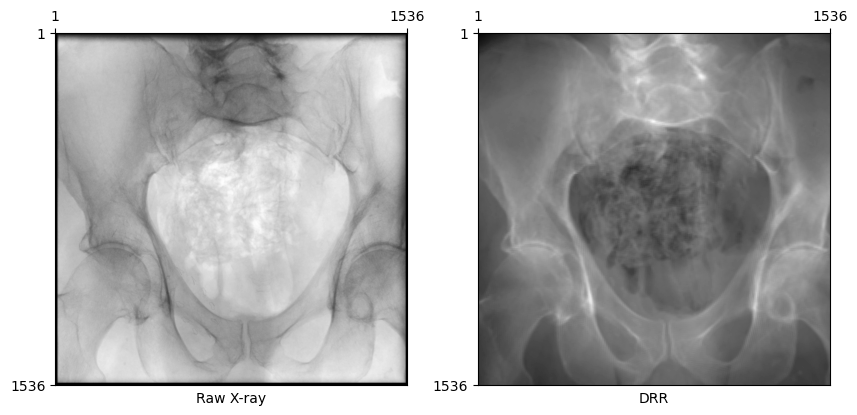

In [ ]:
#| eval: false
# Load a subject from the DeepFluoroDataset WITHOUT preprocessing (non-default)
deepfluoro = DeepFluoroDataset(id_number=1, preprocess=False)

# Initialize the DRR module
drr = DRR(
    deepfluoro.subject,
    deepfluoro.focal_len,
    deepfluoro.height,
    deepfluoro.delx,
    x0=deepfluoro.x0,
    y0=deepfluoro.y0,
    reverse_x_axis=True,
    patch_size=deepfluoro.height // 4,
).cuda()
transform = Transforms(deepfluoro.height)

# Render a DRR from the ground truth camera pose
gt, pose = deepfluoro[0]
img = drr(pose.cuda()).cpu()
gt, img = transform(gt), transform(img)
plot_drr(torch.concat([gt, img]), title=["Raw X-ray", "DRR"])
plt.show()

### Preprocessing X-rays

`DiffDRR` computes the line integral of an X-ray traced over a CT volume. However, X-rays in the `DeepFluoro` dataset come in the exponentiated form. To convert raw X-rays to a linear form such that they look like our DRRs, we need to

- Crop 50 pixels off each edge to remove the effects of the collimator
- Invert the imaging equation to recover the line integral radiograph

From the Beer-Lambert Law, the equation governing fluoroscopy images is
$$ I_f[i, j] = I_0 \exp(-L[i, j]) \,, $$
where $L[i, j]$ is the line integral of an X-ray through the volume. 
Inverting this, we recover
$$ L[i, j] = \log I_0 - \log I_f[i, j] \,.$$
where the constant $I_0$ for each image represents the initial energy of each ray. 
We approximate $I_0 = \max_{i,j} I_f[i,j]$, assuming that this represents a ray that reached the detector plane without first intersecting the volume.

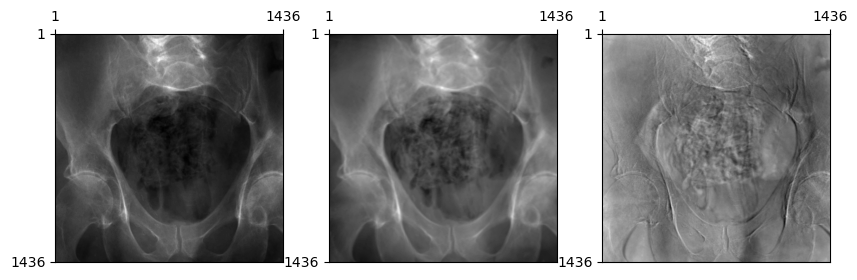

In [ ]:
#| code-fold: true
#| eval: false
# Load a subject from the DeepFluoroDataset WITH preprocessing
deepfluoro = DeepFluoroDataset(id_number=1)

# Initialize the DRR module
drr = DRR(
    deepfluoro.subject,
    deepfluoro.focal_len,
    deepfluoro.height,
    deepfluoro.delx,
    x0=deepfluoro.x0,
    y0=deepfluoro.y0,
    patch_size=deepfluoro.height // 4,
).cuda()
transform = Transforms(deepfluoro.height)

# Render a DRR from the ground truth camera pose
gt, pose = deepfluoro[0]
img = drr(pose.cuda()).cpu()
gt, img = transform(gt), transform(img)
plot_drr(torch.concat([gt, img, gt - img]))
plt.show()

### Changing bone attenuation for DRRs
We can preprocess the CT by segmenting air, soft tissue, and bone before generating DRRs.

- Using `bone_attenuation_multiplier=1.0` (default) sets the value of air voxels to 0
- Increasing `bone_attenuation_multiplier` weights the density of bones higher than that of soft tissue (i.e., increases contrast in the DRR)

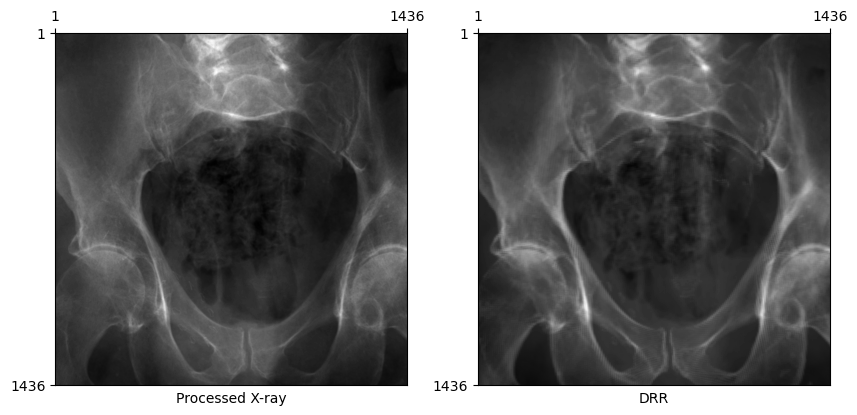

In [ ]:
#| code-fold: true
#| eval: false
# Load a subject from the DeepFluoroDataset WITH preprocessing
deepfluoro = DeepFluoroDataset(id_number=1, bone_attenuation_multiplier=2.5)

# Initialize the DRR module
drr = DRR(
    deepfluoro.subject,
    deepfluoro.focal_len,
    deepfluoro.height,
    deepfluoro.delx,
    x0=deepfluoro.x0,
    y0=deepfluoro.y0,
    patch_size=deepfluoro.height // 4,
).cuda()
transform = Transforms(deepfluoro.height)

# Render a DRR from the ground truth camera pose
gt, pose = deepfluoro[0]
img = drr(pose.cuda()).cpu()
gt, img = transform(gt), transform(img)
plot_drr(torch.concat([gt, img]), title=["Processed X-ray", "DRR"])
plt.show()

Now, DRRs generated from the ground truth C-arm pose looks remarkably similar to the real X-ray!

### Rotated X-ray test

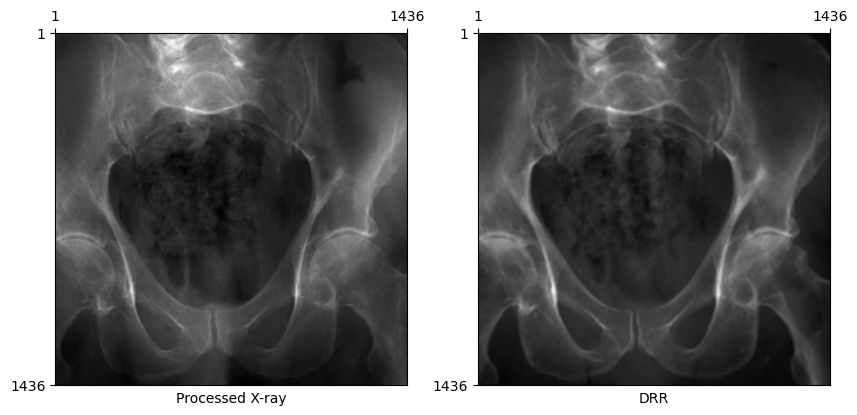

In [ ]:
#| code-fold: true
#| eval: false
# Get an example where the image and pose are rotated
gt, pose = deepfluoro[34]
img = drr(pose.cuda()).cpu()
gt, img = transform(gt), transform(img)
plot_drr(torch.concat([gt, img]), title=["Processed X-ray", "DRR"])
plt.show()

### Rendering smaller X-rays

Rendering such large X-rays is prohibitively slow for online training and optimization schemes. For these purposes, we can simply downsample the X-rays and associated imaging planes we use to render DRRs.

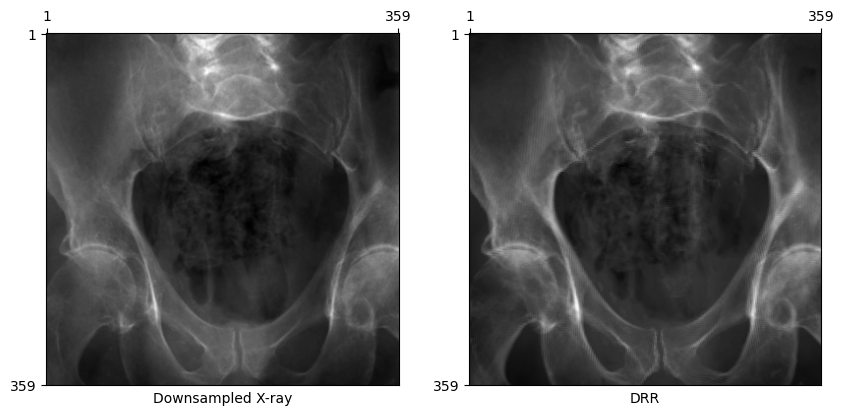

In [ ]:
#| eval: false
# Specify a subsampling factor
subsample = 4

# Load a subject from the DeepFluoroDataset
deepfluoro = DeepFluoroDataset(id_number=1, bone_attenuation_multiplier=2.5)

# Initialize the DRR module WITH subsampling
drr = DRR(
    deepfluoro.subject,
    deepfluoro.focal_len,
    deepfluoro.height // subsample,
    deepfluoro.delx * subsample,
    x0=deepfluoro.x0,
    y0=deepfluoro.y0,
).cuda()
transform = Transforms(deepfluoro.height // subsample)

# Render a DRR from the ground truth camera pose
gt, pose = deepfluoro[0]
img = drr(pose.cuda()).cpu()
gt, img = transform(gt), transform(img)
plot_drr(torch.concat([gt, img]), title=["Downsampled X-ray", "DRR"])
plt.show()

### Projecting fiducial markers

In the `DeepFluoro` dataset, 3D fiducial markers were digitally placed in the preoperative CT. Projecting these markers into 2D using ground truth and estimated camera matrices can be used to calculate mean Reprojection Error (mRPE), a common evaluation metric for 2D/3D registration.

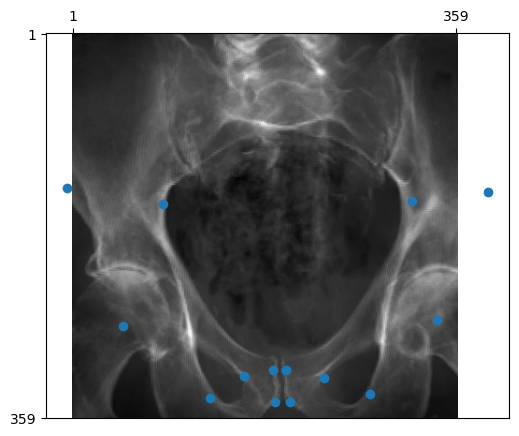

In [ ]:
#| eval: false
x = drr.perspective_projection(pose, deepfluoro.subject.fiducials.cuda()).cpu()
plot_drr(img)
plt.scatter(x[0, ..., 0], x[0, ..., 1])
plt.show()

### Rendering specific structures

Render a specific subset of anatomical structures using a list of `labels`.
For example, to only render the pelvis and spine, use `labels=[1, 2, 3, 4, 7]`.

{1: 'left-hemipelvis', 2: 'right-hemipelvis', 3: 'vertebrae', 4: 'upper-sacrum', 5: 'left-femur', 6: 'right-femur', 7: 'lower-sacrum'}


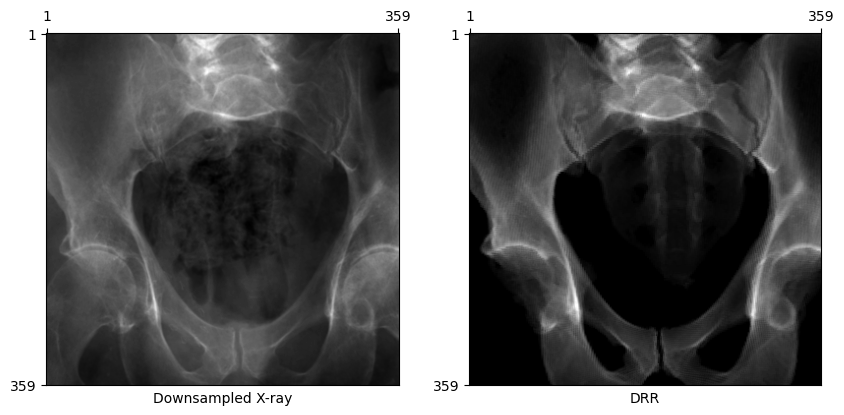

In [ ]:
#| eval: false
# Load a subject from the DeepFluoroDataset
deepfluoro = DeepFluoroDataset(id_number=1, bone_attenuation_multiplier=2.5, labels=[1, 2, 3, 4, 7])
print(deepfluoro.subject.label_def)

# Initialize the DRR module WITH subsampling
drr = DRR(
    deepfluoro.subject,
    deepfluoro.focal_len,
    deepfluoro.height // subsample,
    deepfluoro.delx * subsample,
    x0=deepfluoro.x0,
    y0=deepfluoro.y0,
).cuda()
transform = Transforms(deepfluoro.height // subsample)

# Render a DRR from the ground truth camera pose
gt, pose = deepfluoro[0]
img = drr(pose.cuda()).cpu()
gt, img = transform(gt), transform(img)
plot_drr(torch.concat([gt, img]), title=["Downsampled X-ray", "DRR"])
plt.show()

## Visualizing camera poses in 3D

We can use 3D plotting functions from `PyVista` available in `DiffDRR` to visualize the distributions of camera poses for the six subjects and 366 X-rays in the `DeepFluoro` dataset.

In [ ]:
import pyvista
from IPython.display import IFrame
from tqdm import tqdm

from diffdrr.visualization import _make_camera_frustum_mesh, labelmap_to_mesh

pyvista.start_xvfb()

In [ ]:
#| code-fold: true
#| eval: false
plotter = pyvista.Plotter()


colors = ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f"]
for idx in range(1, 7):
    deepfluoro = DeepFluoroDataset(idx)
    drr = DRR(
        deepfluoro.subject,
        deepfluoro.focal_len,
        deepfluoro.height // 8,
        deepfluoro.delx * 8,
        x0=deepfluoro.x0,
        y0=deepfluoro.y0,
    )

    if idx == 1:
        ct = labelmap_to_mesh(deepfluoro.subject)
        ct.clear_cell_data()
        plotter.add_mesh(ct)

    for img, pose in tqdm(deepfluoro, desc=f"Subject {idx}"):
        source, target = drr.detector(pose, None)
        source = source.squeeze().cpu().detach().numpy()
        target = (
            target.reshape(drr.detector.height, drr.detector.width, 3)
            .cpu()
            .detach()
            .numpy()
        )
        principal_ray = pyvista.Line(source, target.mean(axis=0).mean(axis=0))
        camera = _make_camera_frustum_mesh(source, target, size=0.05)
        plotter.add_mesh(camera, show_edges=True, color=colors[idx - 1])
        plotter.add_mesh(principal_ray, line_width=3, color=colors[idx - 1])

plotter.export_html("deepfluoro_camera_poses.html")

Performing Labeled Surface Extraction: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████[00:00<00:00]
Smoothing Mesh using Taubin Smoothing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████[00:01<00:00]
Cleaning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████[00:00<00:00]
Subject 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00,  9.56it/s]


In this rendering, each rectangular frustum corresponds to the viewing angle for a particular X-ray and each color represents a different subject. For clarity, only the pelvis of the first subject is visualized.

In [ ]:
IFrame("deepfluoro_camera_poses.html", height=500, width=749)

## Citations

**If you use the `DeepFluoro` dataset in your work, please cite the authors' original publication:**

```
@article{grupp2020automatic,
  title={Automatic annotation of hip anatomy in fluoroscopy for robust and efficient 2D/3D registration},
  author={Grupp, Robert B and Unberath, Mathias and Gao, Cong and Hegeman, Rachel A and Murphy, Ryan J and Alexander, Clayton P and Otake, Yoshito and McArthur, Benjamin A and Armand, Mehran and Taylor, Russell H},
  journal={International journal of computer assisted radiology and surgery},
  volume={15},
  pages={759--769},
  year={2020},
  publisher={Springer}
}
```

**If you find `DiffDRR` or `DiffDRR-Datasets` useful for your work, please cite our paper:**

```
@inproceedings{gopalakrishnan2022fast,
  title={Fast auto-differentiable digitally reconstructed radiographs for solving inverse problems in intraoperative imaging},
  author={Gopalakrishnan, Vivek and Golland, Polina},
  booktitle={Workshop on Clinical Image-Based Procedures},
  pages={1--11},
  year={2022},
  organization={Springer}
}
```

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()